In [ ]:
pip install mp_api

In [ ]:
from mp_api.client import MPRester
import pandas as pd

API_KEY = "6SPpGbTvNNX2PVslemAu3GYl9eWUoDRK"  # Replace with your API key

# Optional: list of nonmetals to exclude
non_metals = [
    "H", "He", "C", "N", "F", "Ne", "P", "S", "Cl", "Ar",
    "Se", "Br", "Kr", "I", "Xe", "At", "Rn", "Og", "B"
]

data = []

with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        elements=["O"],                         # Include oxygen (oxides)
        exclude_elements=non_metals,            # Remove non-metal-only materials
        num_elements=(2, 4),                    # Binary to quaternary compounds
        is_stable=True,                         # Thermodynamically stable (e_above_hull ≈ 0)
        # has_icsd=True,                        # Removed: not supported by search directly
        # is_ordered=True,                      # Removed: not supported by search directly
        num_sites=(1, 40),                      # Renamed: nsites -> num_sites
        fields=["material_id", "formula_pretty", "efermi", "band_gap", "structure"]
    )

    for doc in docs:
        data.append({
            "Material ID": doc.material_id,
            "Formula": doc.formula_pretty,
            "E_Fermi (eV)": doc.efermi,
            "Band Gap (eV)": doc.band_gap,
            "structure": doc.structure
        })

df = pd.DataFrame(data)
df.to_csv("filename24.csv", index=False)


Retrieving SummaryDoc documents:   0%|          | 0/3691 [00:00<?, ?it/s]

In [ ]:
df = df[df['Band Gap (eV)'] != 0].reset_index(drop=True)

In [ ]:
df

,Material ID,Formula,E_Fermi (eV),Band Gap (eV),structure
0,mp-11107,Ac2O3,4.696451,3.5226,"[[2.04774562 1.18226451 4.75519851] Ac, [-2.38..."
1,mp-1183115,AcAlO3,6.948866,4.1024,"[[0. 0. 0.] Ac, [1.92931694 1.92931694 1.92931..."
2,mp-866101,AcCrO3,6.364737,2.0031,"[[0. 0. 0.] Ac, [1.97214345 1.97215113 1.97213..."
3,mp-861502,AcFeO3,6.509045,0.9888,"[[0. 0. 0.] Ac, [1.97678086 1.9767782 1.97678..."
4,mp-1183053,AcGaO3,5.476935,2.8959,"[[0. 0. 0.] Ac, [1.97313105 1.97313105 1.97313..."
...,...,...,...,...,...
2817,mp-10560,Sm3AuO6,2.109906,1.7477,"[[2.1542284 2.98325261 4.87541844] Sm, [1.359..."
2818,mp-1105484,Sm3FeO6,1.883765,1.4942,"[[6.28159335 1.20332837 0.23686309] Sm, [2.785..."
2819,mp-31110,Sm3GaO6,1.721003,3.6796,"[[0.42507793 4.28412506 1.90524952] Sm, [3.191..."
2820,mp-3154,Sm3Sb5O12,3.858255,3.1427,[[-1.92777852e-06 2.72985643e+00 5.45970971e...


In [ ]:
pip install matminer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.5 MB/s eta 0:00:00


In [ ]:
from pymatgen.core import Structure
from matminer.featurizers.structure import (
    DensityFeatures,
    GlobalSymmetryFeatures,
    StructuralHeterogeneity,
    RadialDistributionFunction,
    SineCoulombMatrix,
    BondFractions,
    SiteStatsFingerprint
)
from matminer.featurizers.site import OPSiteFingerprint
import pandas as pd

# Convert any dicts in 'structure' column to pymatgen Structure objects
df["structure"] = df["structure"].apply(
    lambda s: Structure.from_dict(s) if isinstance(s, dict) else s
)

# Drop columns if they exist to avoid conflicts with new features
for col in ["density", "vpa"]:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Define structural featurizers
featurizers = [
    DensityFeatures(),
    GlobalSymmetryFeatures(),
    RadialDistributionFunction(),
    SineCoulombMatrix(),
    StructuralHeterogeneity(),
    SiteStatsFingerprint(OPSiteFingerprint()),
]

# Apply each featurizer
for feat in featurizers:
    if hasattr(feat, "fit"):
        try:
            feat.fit(df["structure"])
        except Exception as e:
            print(f"Featurizer {type(feat).__name__} fit error: {e}")
    try:
        df = feat.featurize_dataframe(df, "structure", ignore_errors=True)
    except Exception as e:
        print(f"Featurizer {type(feat).__name__} featurization error: {e}")


DensityFeatures:   0%|          | 0/2822 [00:00<?, ?it/s]

GlobalSymmetryFeatures:   0%|          | 0/2822 [00:00<?, ?it/s]

RadialDistributionFunction:   0%|          | 0/2822 [00:00<?, ?it/s]

SineCoulombMatrix:   0%|          | 0/2822 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
/usr/local/lib/python3.11/dist-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
/usr/local/lib/python3.11/dist-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
/usr/local/lib/python3.11/dist-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
/usr/local/lib/python3.11/dist-packages/matminer/featurizers/structure/matrix.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  zeros[: len(eigs)] = eigs
/usr/local/lib/python3.11/dist-packages/matminer/featur

StructuralHeterogeneity:   0%|          | 0/2822 [00:00<?, ?it/s]

SiteStatsFingerprint:   0%|          | 0/2822 [00:00<?, ?it/s]

In [ ]:
df.to_csv("final.csv", index=False)

In [ ]:
import pandas as pd
from pymatgen.core.composition import Composition
from matminer.featurizers.composition import (
    ElementProperty, ValenceOrbital, BandCenter,
    ElectronegativityDiff, AtomicOrbitals, Meredig
)

# Load dataset
df = pd.read_csv('final.csv')

# Convert chemical formulas to Composition objects
df['composition_obj'] = df['Formula'].apply(Composition)

# Store original df to merge features later
base_df = df.copy()

# Featurizers most relevant for Fermi energy prediction
featurizers = [
    ElementProperty.from_preset("magpie"),
    ValenceOrbital(),
    BandCenter(),
    ElectronegativityDiff(),
    AtomicOrbitals(),
    Meredig()
]

# Apply each featurizer to a copy of the base DataFrame and merge results
feature_dfs = []
for feat in featurizers:
    temp_df = base_df.copy()
    temp_df = feat.featurize_dataframe(temp_df, col_id='composition_obj', ignore_errors=True)
    feature_cols = temp_df.columns.difference(base_df.columns)  # Only new feature columns
    feature_dfs.append(temp_df[feature_cols])

# Concatenate all feature sets horizontally
all_features = pd.concat(feature_dfs, axis=1)
result_df = pd.concat([base_df, all_features], axis=1)

# Save to CSV
result_df.to_csv("fermi_energy_features_with_meredig.csv", index=False)

# Show first few rows
result_df.head()


/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
/usr/local/lib/python3.11/dist-packages/matminer/featurizers/composition/orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
        

ElementProperty:   0%|          | 0/2822 [00:00<?, ?it/s]

ValenceOrbital:   0%|          | 0/2822 [00:00<?, ?it/s]

BandCenter:   0%|          | 0/2822 [00:00<?, ?it/s]

ElectronegativityDiff:   0%|          | 0/2822 [00:00<?, ?it/s]

AtomicOrbitals:   0%|          | 0/2822 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pymatgen/core/molecular_orbitals.py:56: UserWarning: No data available for atomic_orbitals for Pu
  self.aos = {str(el): [[str(el), k, v] for k, v in Element(el).atomic_orbitals.items()] for el in self.elements}
/usr/local/lib/python3.11/dist-packages/pymatgen/core/molecular_orbitals.py:56: UserWarning: No data available for atomic_orbitals for Pu
  self.aos = {str(el): [[str(el), k, v] for k, v in Element(el).atomic_orbitals.items()] for el in self.elements}
/usr/local/lib/python3.11/dist-packages/pymatgen/core/molecular_orbitals.py:56: UserWarning: No data available for atomic_orbitals for Np
  self.aos = {str(el): [[str(el), k, v] for k, v in Element(el).atomic_orbitals.items()] for el in self.elements}
/usr/local/lib/python3.11/dist-packages/pymatgen/core/molecular_orbitals.py:56: UserWarning: No data available for atomic_orbitals for Np
  self.aos = {str(el): [[str(el), k, v] for k, v in Element(el).atomic_orbitals.items()] for el in self.el

Meredig:   0%|          | 0/2822 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/matminer/featurizers/composition/orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
/usr/local/lib/python3.11/dist-packages/matminer/featurizers/composition/orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of tha

,Material ID,Formula,E_Fermi (eV),Band Gap (eV),structure,density,vpa,packing fraction,spacegroup_num,crystal_system,...,frac s valence electrons,mean AtomicRadius,mean AtomicWeight,mean Column,mean Electronegativity,mean Number,mean Row,range AtomicRadius,range Electronegativity,range Number
0,mp-11107,Ac2O3,4.696451,3.5226,Full Formula (Ac2 O3)\nReduced Formula: Ac2O3\...,9.109130,18.302245,0.708471,164,trigonal,...,0.416667,1.14,100.399640,10.8,2.504,40.4,4.0,1.35,2.34,81.0
1,mp-1183115,AcAlO3,6.948866,4.1024,Full Formula (Ac1 Al1 O3)\nReduced Formula: Ac...,8.728230,11.490283,0.730268,221,cubic,...,0.416667,1.00,60.395948,12.8,2.606,25.2,3.2,1.35,2.34,81.0
2,mp-866101,AcCrO3,6.364737,2.0031,Full Formula (Ac1 Cr1 O3)\nReduced Formula: Ac...,8.848788,12.272569,0.737706,221,cubic,...,0.333333,1.03,65.398860,11.4,2.616,27.4,3.4,1.35,2.34,81.0
3,mp-861502,AcFeO3,6.509045,0.9888,Full Formula (Ac1 Fe1 O3)\nReduced Formula: Ac...,8.889999,12.359462,0.732519,221,cubic,...,0.344828,1.03,66.168640,11.8,2.650,27.8,3.4,1.35,2.34,81.0
4,mp-1183053,AcGaO3,5.476935,2.8959,Full Formula (Ac1 Ga1 O3)\nReduced Formula: Ac...,9.314495,12.291016,0.699315,221,cubic,...,0.294118,1.01,68.944240,12.8,2.646,28.8,3.4,1.35,2.34,81.0


,Material ID,Formula,E_Fermi (eV),Band Gap (eV),structure,density,vpa,packing fraction,spacegroup_num,crystal_system,...,frac s valence electrons,mean AtomicRadius,mean AtomicWeight,mean Column,mean Electronegativity,mean Number,mean Row,range AtomicRadius,range Electronegativity,range Number
0,mp-11107,Ac2O3,4.696451,3.5226,Full Formula (Ac2 O3)\nReduced Formula: Ac2O3\...,9.109130,18.302245,0.708471,164,trigonal,...,0.416667,1.140000,100.399640,10.800000,2.504000,40.400000,4.000000,1.35,2.34,81.0
1,mp-1183115,AcAlO3,6.948866,4.1024,Full Formula (Ac1 Al1 O3)\nReduced Formula: Ac...,8.728230,11.490283,0.730268,221,cubic,...,0.416667,1.000000,60.395948,12.800000,2.606000,25.200000,3.200000,1.35,2.34,81.0
2,mp-866101,AcCrO3,6.364737,2.0031,Full Formula (Ac1 Cr1 O3)\nReduced Formula: Ac...,8.848788,12.272569,0.737706,221,cubic,...,0.333333,1.030000,65.398860,11.400000,2.616000,27.400000,3.400000,1.35,2.34,81.0
3,mp-861502,AcFeO3,6.509045,0.9888,Full Formula (Ac1 Fe1 O3)\nReduced Formula: Ac...,8.889999,12.359462,0.732519,221,cubic,...,0.344828,1.030000,66.168640,11.800000,2.650000,27.800000,3.400000,1.35,2.34,81.0
4,mp-1183053,AcGaO3,5.476935,2.8959,Full Formula (Ac1 Ga1 O3)\nReduced Formula: Ac...,9.314495,12.291016,0.699315,221,cubic,...,0.294118,1.010000,68.944240,12.800000,2.646000,28.800000,3.400000,1.35,2.34,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,mp-10560,Sm3AuO6,2.109906,1.7477,Full Formula (Sm3 Au1 O6)\nReduced Formula: Sm...,8.522126,14.497701,0.657347,2,triclinic,...,0.223529,1.050000,74.404297,11.600000,2.669000,31.300000,3.600000,1.25,2.27,71.0
2818,mp-1105484,Sm3FeO6,1.883765,1.4942,Full Formula (Sm6 Fe2 O12)\nReduced Formula: S...,6.997853,14.306881,0.674419,36,orthorhombic,...,0.294118,1.055000,60.292140,11.300000,2.598000,26.000000,3.400000,1.25,2.27,54.0
2819,mp-31110,Sm3GaO6,1.721003,3.6796,Full Formula (Sm6 Ga2 O12)\nReduced Formula: S...,7.171262,14.282278,0.659538,36,orthorhombic,...,0.273973,1.045000,61.679940,11.800000,2.596000,26.500000,3.400000,1.25,2.27,54.0
2820,mp-3154,Sm3Sb5O12,3.858255,3.1427,Full Formula (Sm6 Sb10 O24)\nReduced Formula: ...,6.386584,16.274613,0.473969,217,cubic,...,0.233918,1.000000,62.593640,13.800000,2.752000,26.850000,3.350000,1.25,2.27,54.0


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load your data
df = pd.read_csv('calculation.csv')

# List of all categorical columns to encode
categorical_cols = ['crystal_system', 'is_centrosymmetric', 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']

# Extract those columns
categorical_data = df[categorical_cols]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the categorical data
encoded = encoder.fit_transform(categorical_data)

# Convert encoded data to a DataFrame with proper column names
encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(categorical_cols))

# Combine with the rest of the original DataFrame (excluding the original categorical columns)
df_encoded = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

# Now df_encoded is ready for ML modeling
print(df_encoded.head())


  Material ID Formula  E_Fermi (eV)  Band Gap (eV)  \
0    mp-11107   Ac2O3      4.696451         3.5226   
1  mp-1183115  AcAlO3      6.948866         4.1024   
2   mp-866101  AcCrO3      6.364737         2.0031   
3   mp-861502  AcFeO3      6.509045         0.9888   
4  mp-1183053  AcGaO3      5.476935         2.8959   

                                           structure   density        vpa  \
0  Full Formula (Ac2 O3)\nReduced Formula: Ac2O3\...  9.109130  18.302245   
1  Full Formula (Ac1 Al1 O3)\nReduced Formula: Ac...  8.728230  11.490283   
2  Full Formula (Ac1 Cr1 O3)\nReduced Formula: Ac...  8.848788  12.272569   
3  Full Formula (Ac1 Fe1 O3)\nReduced Formula: Ac...  8.889999  12.359462   
4  Full Formula (Ac1 Ga1 O3)\nReduced Formula: Ac...  9.314495  12.291016   

   packing fraction  spacegroup_num  crystal_system_int  ...  LUMO_element_Ti  \
0          0.708471             164                   3  ...              0.0   
1          0.730268             221               

In [ ]:
df_encoded.to_csv("encoded_data.csv", index=False)

In [ ]:
df_encoded

,Material ID,Formula,E_Fermi (eV),Band Gap (eV),structure,density,vpa,packing fraction,spacegroup_num,crystal_system_int,...,LUMO_element_Ti,LUMO_element_Tl,LUMO_element_Tm,LUMO_element_V,LUMO_element_W,LUMO_element_Y,LUMO_element_Yb,LUMO_element_Zn,LUMO_element_Zr,LUMO_element_nan
0,mp-11107,Ac2O3,4.696451,3.5226,Full Formula (Ac2 O3)\nReduced Formula: Ac2O3\...,9.109130,18.302245,0.708471,164,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,mp-1183115,AcAlO3,6.948866,4.1024,Full Formula (Ac1 Al1 O3)\nReduced Formula: Ac...,8.728230,11.490283,0.730268,221,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,mp-866101,AcCrO3,6.364737,2.0031,Full Formula (Ac1 Cr1 O3)\nReduced Formula: Ac...,8.848788,12.272569,0.737706,221,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mp-861502,AcFeO3,6.509045,0.9888,Full Formula (Ac1 Fe1 O3)\nReduced Formula: Ac...,8.889999,12.359462,0.732519,221,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,mp-1183053,AcGaO3,5.476935,2.8959,Full Formula (Ac1 Ga1 O3)\nReduced Formula: Ac...,9.314495,12.291016,0.699315,221,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,mp-10560,Sm3AuO6,2.109906,1.7477,Full Formula (Sm3 Au1 O6)\nReduced Formula: Sm...,8.522126,14.497701,0.657347,2,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2818,mp-1105484,Sm3FeO6,1.883765,1.4942,Full Formula (Sm6 Fe2 O12)\nReduced Formula: S...,6.997853,14.306881,0.674419,36,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2819,mp-31110,Sm3GaO6,1.721003,3.6796,Full Formula (Sm6 Ga2 O12)\nReduced Formula: S...,7.171262,14.282278,0.659538,36,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2820,mp-3154,Sm3Sb5O12,3.858255,3.1427,Full Formula (Sm6 Sb10 O24)\nReduced Formula: ...,6.386584,16.274613,0.473969,217,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = df_encoded.drop(columns=["Material ID", "Formula", "structure"])

In [ ]:
df

,E_Fermi (eV),Band Gap (eV),density,vpa,packing fraction,spacegroup_num,crystal_system_int,n_symmetry_ops,rdf [0.00000 - 0.10000]A,rdf [0.10000 - 0.20000]A,...,LUMO_element_Ti,LUMO_element_Tl,LUMO_element_Tm,LUMO_element_V,LUMO_element_W,LUMO_element_Y,LUMO_element_Yb,LUMO_element_Zn,LUMO_element_Zr,LUMO_element_nan
0,4.696451,3.5226,9.109130,18.302245,0.708471,164,3,24,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.948866,4.1024,8.728230,11.490283,0.730268,221,1,96,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.364737,2.0031,8.848788,12.272569,0.737706,221,1,48,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.509045,0.9888,8.889999,12.359462,0.732519,221,1,48,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.476935,2.8959,9.314495,12.291016,0.699315,221,1,96,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,2.109906,1.7477,8.522126,14.497701,0.657347,2,7,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2818,1.883765,1.4942,6.997853,14.306881,0.674419,36,5,4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2819,1.721003,3.6796,7.171262,14.282278,0.659538,36,5,8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2820,3.858255,3.1427,6.386584,16.274613,0.473969,217,1,48,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.to_csv("readydataset.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv('rreadydataset.csv')  # Change filename if needed

# Drop rows where the target variable 'E_Fermi (eV)' is NaN
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


R² Score: 0.6617
Mean Squared Error (MSE): 1.0237
Mean Absolute Error (MAE): 0.7295


In [ ]:
df.isnull()

,E_Fermi (eV),Band Gap (eV),density,vpa,packing fraction,spacegroup_num,crystal_system_int,n_symmetry_ops,rdf [0.00000 - 0.10000]A,rdf [0.10000 - 0.20000]A,...,LUMO_element_Ti,LUMO_element_Tl,LUMO_element_Tm,LUMO_element_V,LUMO_element_W,LUMO_element_Y,LUMO_element_Yb,LUMO_element_Zn,LUMO_element_Zr,LUMO_element_nan
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2818,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2819,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2820,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df = df[df['band center'] != 0].reset_index(drop=True)

In [ ]:
df.to_csv("finall.csv", index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv('finall.csv')  # Change filename if needed

# Drop rows where the target variable 'E_Fermi (eV)' is NaN
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Train the Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


R² Score: 0.6736
Mean Squared Error (MSE): 0.9704
Mean Absolute Error (MAE): 0.6823


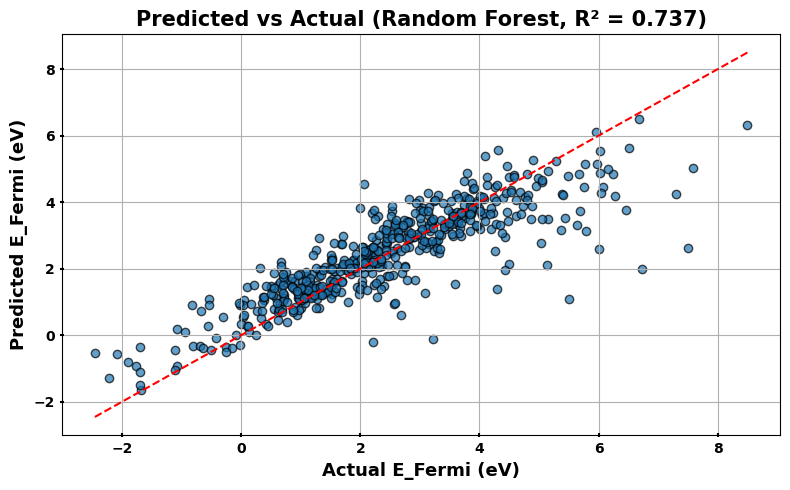

In [ ]:
import matplotlib.pyplot as plt

# Parity Plot: Predicted vs Actual (Random Forest)
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line

# Set axis labels with specified font size and weight
plt.xlabel('Actual E_Fermi (eV)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted E_Fermi (eV)', fontsize=13, fontweight='bold')

# Set bold title with larger font size
plt.title(f'Predicted vs Actual (Random Forest, R² = {r2:.3f})', fontsize=15, fontweight='bold')

# Set tick direction and bold tick labels
plt.tick_params(direction='inout', labelsize=10, width=1.5)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig("parity_plot_random_forest.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('finall.csv')  # Ensure 'output.csv' exists and is formatted correctly

# Drop rows with missing values in the target column
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])  # Features
y = df['E_Fermi (eV)']                # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 🔁 Predict on training set
y_train_pred = model.predict(X_train)

# 🔍 Evaluate performance on training set
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

# 📊 Print training set performance metrics
print("Training Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Training Set Performance:
R² Score: 0.9527
Mean Squared Error (MSE): 0.1339
Mean Absolute Error (MAE): 0.2583


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

# Load data
df = pd.read_csv('finall.csv')  # Change filename if needed

# Drop rows where the target variable 'E_Fermi (eV)' is NaN
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Perform 5-fold cross-validation using R² score
r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

# Print individual R² scores and their average
print("R² scores for each fold:", r2_scores)
print("Average R² score:", r2_scores.mean())


R² scores for each fold: [0.38606142 0.60170856 0.7005777  0.47005244 0.61877581]
Average R² score: 0.5554351856953671


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load the dataset
df = pd.read_csv('finall.csv')  # Change filename if needed

# Drop rows with missing target values
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanitize column names for XGBoost
# Replace problematic characters [, ], < with underscores
X_train.columns = X_train.columns.str.replace('[\[\]<>]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<>]', '_', regex=True)

# Train the XGBoost Regressor
model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print evaluation metrics
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


R² Score: 0.7371
Mean Squared Error (MSE): 0.7815
Mean Absolute Error (MAE): 0.6040


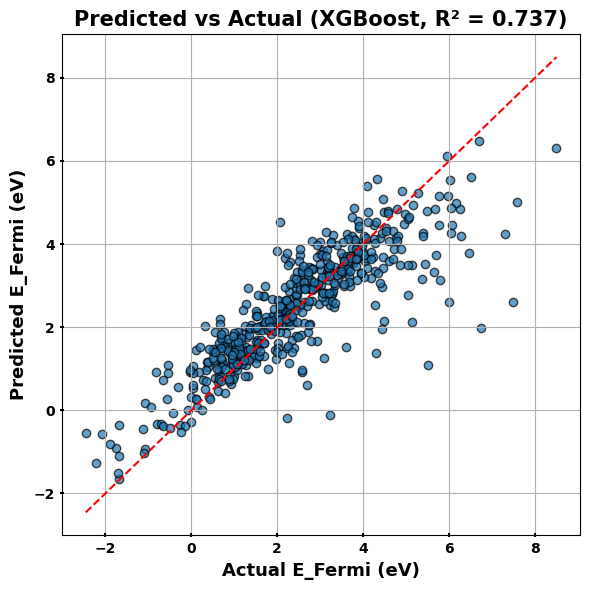

In [ ]:
import matplotlib.pyplot as plt

# Parity Plot: Predicted vs Actual (XGBoost)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line

# Set axis labels with specified font size and weight
plt.xlabel('Actual E_Fermi (eV)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted E_Fermi (eV)', fontsize=13, fontweight='bold')

# Set bold title with larger font size
plt.title(f'Predicted vs Actual (XGBoost, R² = {r2:.3f})', fontsize=15, fontweight='bold')

# Set tick direction and bold tick labels
plt.tick_params(direction='inout', labelsize=10, width=1.5)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig("parity_plot_xgboost.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# Load the dataset
df = pd.read_csv('finall.csv')  # Ensure the file exists

# Drop rows with missing target values
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])  # Features
y = df['E_Fermi (eV)']                # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Sanitize column names for XGBoost
X_train.columns = X_train.columns.str.replace('[\[\]<>]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<>]', '_', regex=True)

# Train the XGBoost Regressor
model = XGBRegressor(
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)
model.fit(X_train, y_train)

# 🔁 Predict and evaluate on training set
y_train_pred = model.predict(X_train)
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

# Print evaluation metrics for training set
print("Training Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Training Set Performance:
R² Score: 0.9776
Mean Squared Error (MSE): 0.0633
Mean Absolute Error (MAE): 0.1807


In [ ]:
pip install lightgbm


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('finall.csv')  # Replace with your actual file

# Drop rows with missing target values
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# No scaling needed for LGBM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanitize column names for LightGBM
X_train.columns = X_train.columns.str.replace('[\[\]<>]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<>]', '_', regex=True)

# Train the LightGBM Regressor
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print evaluation metrics
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92560
[LightGBM] [Info] Number of data points in the train set: 2131, number of used features: 585
[LightGBM] [Info] Start training from score 2.397947
R² Score: 0.7360
Mean Squared Error (MSE): 0.7849
Mean Absolute Error (MAE): 0.5977


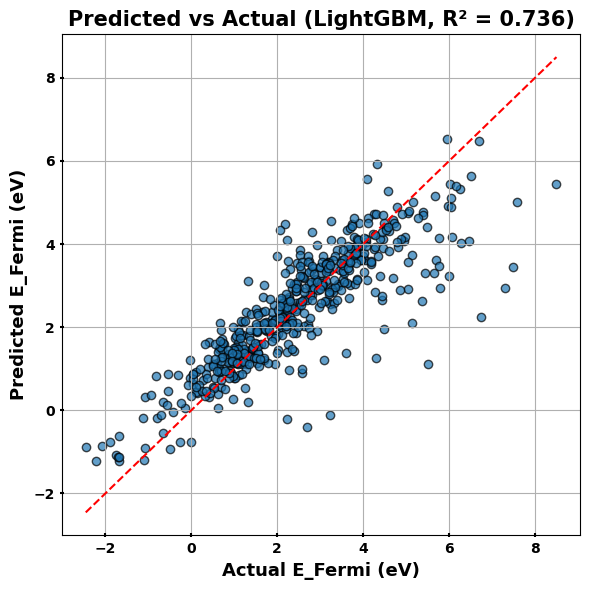

In [ ]:
import matplotlib.pyplot as plt

# Parity Plot: Predicted vs Actual (LightGBM)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line

# Set axis labels with specified font size and weight
plt.xlabel('Actual E_Fermi (eV)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted E_Fermi (eV)', fontsize=13, fontweight='bold')

# Set bold title with larger font size
plt.title(f'Predicted vs Actual (LightGBM, R² = {r2:.3f})', fontsize=15, fontweight='bold')

# Set tick direction and bold tick labels
plt.tick_params(direction='inout', labelsize=10, width=1.5)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig("parity_plot_lightgbm.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('finall.csv')  # Ensure your file path is correct

# Drop rows with missing values in the target column
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])  # Features
y = df['E_Fermi (eV)']                # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Sanitize column names for LightGBM
X_train.columns = X_train.columns.str.replace('[\[\]<>]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]<>]', '_', regex=True)

# Initialize and train the LightGBM Regressor
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)
model.fit(X_train, y_train)

# 🔁 Predict on the training set
y_train_pred = model.predict(X_train)

# 🔍 Evaluate performance on the training set
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

# 📊 Print training set performance metrics
print("Training Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92560
[LightGBM] [Info] Number of data points in the train set: 2131, number of used features: 585
[LightGBM] [Info] Start training from score 2.397947
Training Set Performance:
R² Score: 0.9856
Mean Squared Error (MSE): 0.0408
Mean Absolute Error (MAE): 0.1468


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('finall.csv')  # Replace with your actual file

# Drop rows with missing target values
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# No need for feature scaling or encoding for CatBoost
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the CatBoost Regressor
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0  # Set to 100 to see training progress
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print evaluation metrics
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


R² Score: 0.7535
Mean Squared Error (MSE): 0.7329
Mean Absolute Error (MAE): 0.5611


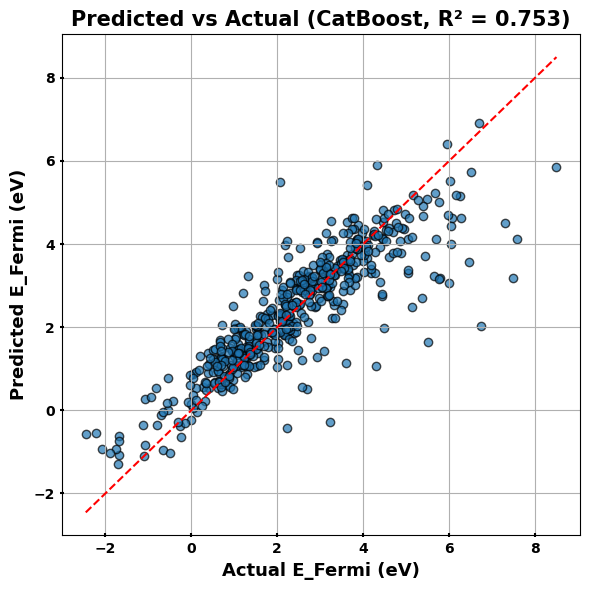

In [ ]:
import matplotlib.pyplot as plt

# Parity Plot: Predicted vs Actual (CatBoost)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line

# Set axis labels with specified font size and weight
plt.xlabel('Actual E_Fermi (eV)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted E_Fermi (eV)', fontsize=13, fontweight='bold')

# Set bold title with larger font size
plt.title(f'Predicted vs Actual (CatBoost, R² = {r2:.3f})', fontsize=15, fontweight='bold')

# Set tick direction and bold tick labels
plt.tick_params(direction='inout', labelsize=10, width=1.5)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig("parity_plot_catboost.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv('finall.csv')  # Ensure the file path and structure are correct

# Drop rows with missing target values
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])  # Features
y = df['E_Fermi (eV)']                # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the CatBoost Regressor
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=0  # Set to 100 to see training progress during fit
)
model.fit(X_train, y_train)

# 🔁 Predict on the training set
y_train_pred = model.predict(X_train)

# 🔍 Evaluate performance on the training set
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

# 📊 Print training set performance metrics
print("Training Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


Training Set Performance:
R² Score: 0.9848
Mean Squared Error (MSE): 0.0431
Mean Absolute Error (MAE): 0.1566


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv('finall.csv')  # Ensure the file is correctly formatted

# Drop rows with missing target values
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])  # Features
y = df['E_Fermi (eV)']                # Target

# Impute missing values in X
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Standardize features (important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Train the KNeighbors Regressor
model = KNeighborsRegressor(
    n_neighbors=5,
    weights='uniform',
    metric='minkowski'
)
model.fit(X_train, y_train)

# 🔁 Predict on the training set
y_train_pred = model.predict(X_train)

# 🔍 Evaluate performance on the training set
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

# 📊 Print training set performance metrics
print("KNN Training Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


KNN Training Set Performance:
R² Score: 0.6713
Mean Squared Error (MSE): 0.9304
Mean Absolute Error (MAE): 0.6926


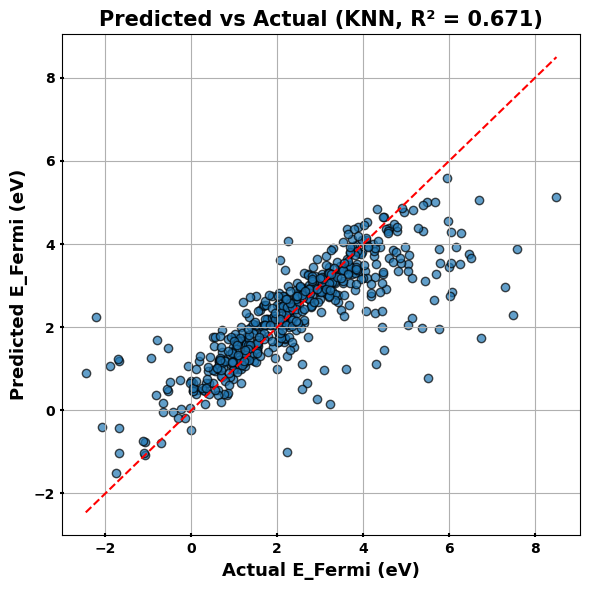

In [ ]:
import matplotlib.pyplot as plt

# Parity Plot: Predicted vs Actual (KNN)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line

# Set axis labels with specified font size and weight
plt.xlabel('Actual E_Fermi (eV)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted E_Fermi (eV)', fontsize=13, fontweight='bold')

# Set bold title with larger font size
plt.title(f'Predicted vs Actual (KNN, R² = {r2:.3f})', fontsize=15, fontweight='bold')

# Set tick direction and bold tick labels
plt.tick_params(direction='inout', labelsize=10, width=1.5)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig("parity_plot_knn.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Load and prepare the dataset
df = pd.read_csv('finall.csv')  # Replace with your actual file
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

X = df.drop(columns=['E_Fermi (eV)'])
y = df['E_Fermi (eV)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipeline: Imputer → Scaler → SVR
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=1.0, epsilon=0.1))
])

# Fit on training data and predict on test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"Test R² Score: {r2:.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")


Test R² Score: 0.6396
Test Mean Squared Error (MSE): 1.0715
Test Mean Absolute Error (MAE): 0.6452


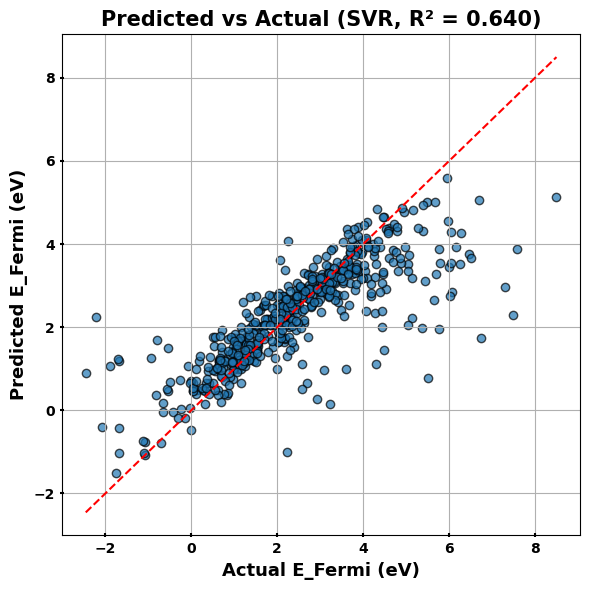

In [ ]:
import matplotlib.pyplot as plt

# Parity Plot: Predicted vs Actual (SVR)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line

# Set axis labels with specified font size and weight
plt.xlabel('Actual E_Fermi (eV)', fontsize=13, fontweight='bold')
plt.ylabel('Predicted E_Fermi (eV)', fontsize=13, fontweight='bold')

# Set bold title with larger font size
plt.title(f'Predicted vs Actual (SVR, R² = {r2:.3f})', fontsize=15, fontweight='bold')

# Set tick direction and bold tick labels
plt.tick_params(direction='inout', labelsize=10, width=1.5)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.grid(True)
plt.tight_layout()

# Save the figure before showing it
plt.savefig("parity_plot_svr.png", dpi=300)

# Display the plot
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Load and prepare the dataset
df = pd.read_csv('finall.csv')  # Ensure the file exists and is properly formatted
df.dropna(subset=['E_Fermi (eV)'], inplace=True)

# Define features and target
X = df.drop(columns=['E_Fermi (eV)'])  # Features
y = df['E_Fermi (eV)']                # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define preprocessing + model pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),     # Handle missing values
    ('scaler', StandardScaler()),                    # Standardize features
    ('model', SVR(kernel='rbf', C=1.0, epsilon=0.1))  # Support Vector Regressor
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# 🔁 Predict on the training set
y_train_pred = pipeline.predict(X_train)

# 🔍 Evaluate performance on the training set
r2 = r2_score(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
mae = mean_absolute_error(y_train, y_train_pred)

# 📊 Print training set performance metrics
print("SVR Training Set Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")


SVR Training Set Performance:
R² Score: 0.8010
Mean Squared Error (MSE): 0.5634
Mean Absolute Error (MAE): 0.3766
